# Tutorial: Differentiable Information Imbalance (JAX implementation)

The Differentiable Information Imbalance (DII) is a tool to automatically learn the optimal distance function A to predict close pair of points in a target distance space B. 

This notebook shows a brief tutorial of the JAX implementation of the DII, available in the 'DiffImbalance' class. For more information, please refer to the diff_imbalance module in the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html

In [1]:
from dadapy import DiffImbalance
import matplotlib.pyplot as plt
import numpy as np
import os
import jax

jax.config.update('jax_platform_name', 'gpu') # can run on 'cpu' or 'gpu'; restart the
                                              # notebook kernel to make this change effective
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false' # avoid jax memory preallocation

In [2]:
%load_ext autoreload
%autoreload 2

## Optimization on a 5D anisotropic Gaussian dataset

In this example we show how to optimize the weights $\{w_\alpha\}$ of the features $\{X_\alpha\}$ in a space A $(\alpha=1,...,D)$ in order to optimize the prediction of the distances measured in a target space B. We will construct space A using a 5-dimensional isotropic Gaussian distribution, and space B by reweighting its coordinates, resulting in a 5-dimensional anisotropic Gaussian.

The weights appear in the distance function as
\begin{equation}
d_{ij}^A(\{w_\alpha\}) = \Bigg[\sum_{\alpha=1}^D\,(w_{\alpha}X_\alpha^i - w_{\alpha}X_\alpha^j) \Bigg]^{1/2},
\end{equation}
and they are optimized by gradient descent.

In [3]:
# generate test data
weights_ground_truth = np.array([10,3,1,30,7.3])
np.random.seed(0)
data_A = np.random.normal(loc=0, scale=1.0, size=(2000,5))
data_B = weights_ground_truth[np.newaxis,:] * data_A
print(f"Ground truth weights = {weights_ground_truth}\n")

# train the DII to recover ground-truth metric
imbs = {}
weights = {}
dii = DiffImbalance(
    data_A,
    data_B,
    periods_A=None, 
    periods_B=None, 
    seed=0,
    num_epochs=1000,
    batches_per_epoch=1,
    l1_strength=0.0,
    point_adapt_lambda=False,
    k_init=1,
    k_final=1,
    lambda_init=None,
    lambda_final=None,
    init_params=None,
    optimizer_name="sgd",
    learning_rate=0.1,
    learning_rate_decay=False,
    compute_error=False,
    ratio_rows_columns=1,
)
weights, imbs = dii.train()

# scale learnt weights in same range of ground-truth ones (same magnitude of the largest one)
print(f"Learnt weights: {np.abs(weights[-1]) / (np.max(np.abs(weights[-1])) / np.max(weights_ground_truth))}")

Ground truth weights = [10.   3.   1.  30.   7.3]



2024-07-08 17:59:10.878108: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


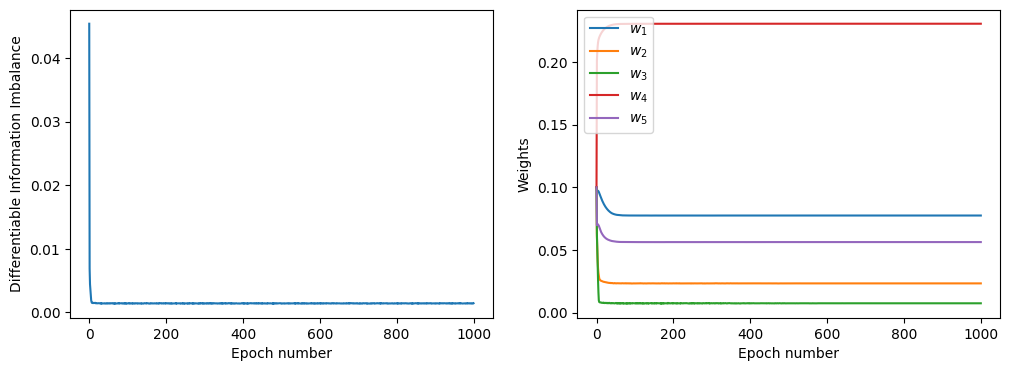

In [ ]:
# plot the DII and the weights during the training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(imbs)
ax2.plot(weights[:,0], label="$w_1$")
ax2.plot(weights[:,1], label="$w_2$")
ax2.plot(weights[:,2], label="$w_3$")
ax2.plot(weights[:,3], label="$w_4$")
ax2.plot(weights[:,4], label="$w_5$")

ax1.set(ylabel="Differentiable Information Imbalance", xlabel="Epoch number")
ax2.set(ylabel="Weights", xlabel="Epoch number")
ax2.legend()
plt.show()